# Performance of different models w and w/o abstraction or finetuning

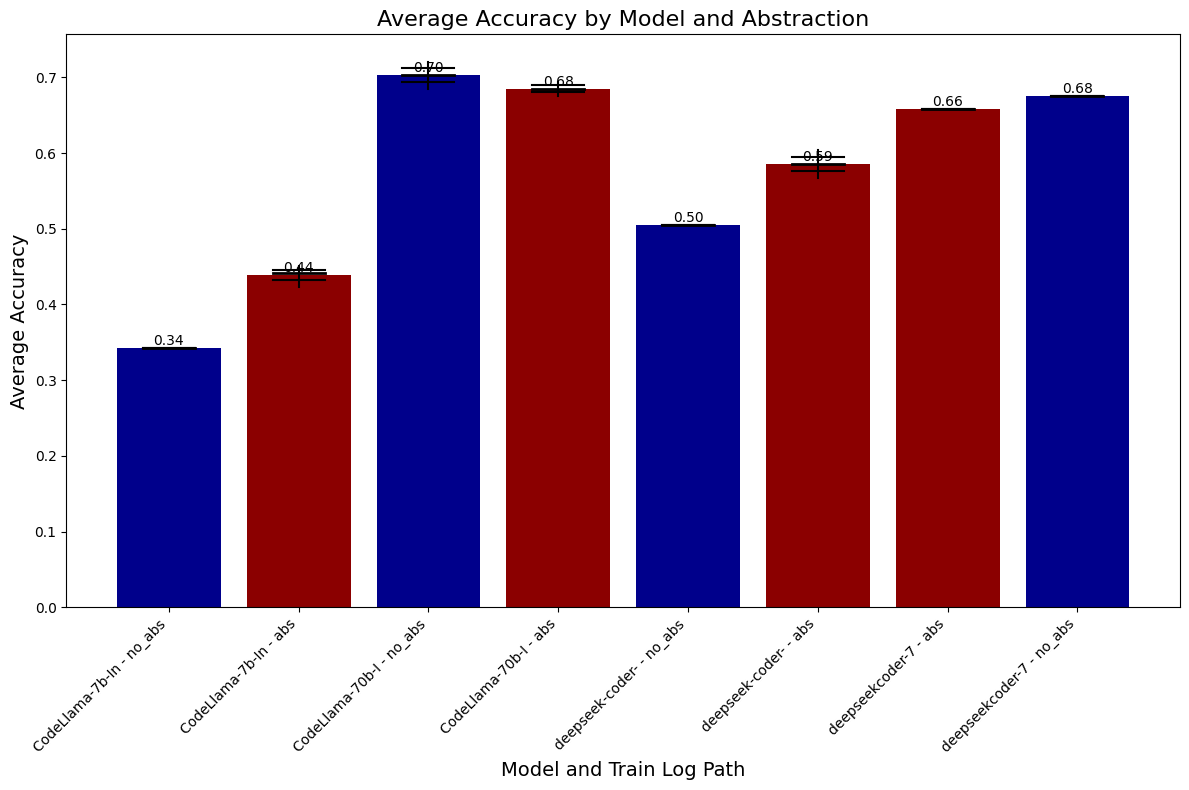

In [2]:
# Import the necessary libraries
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Function to extract values from args.json and stats.json
def get_train_log_model_and_acc(root_folder):
    grouped_data = defaultdict(lambda: defaultdict(list))

    # Traverse through the root folder and all its subfolders
    for subdir, _, files in os.walk(root_folder):
        if 'args.json' in files and 'stats.json' in files:
            args_file = os.path.join(subdir, 'args.json')
            stats_file = os.path.join(subdir, 'stats.json')

            # Read args.json and get the value of "train_log_path" and "model_name"
            with open(args_file, 'r') as f:
                args_data = json.load(f)
                train_log_path = args_data.get('train_log_path')
                model_name = args_data.get('model_name')

            # Read stats.json and check "correct" + "incorrect" == 111 before considering the folder
            with open(stats_file, 'r') as f:
                stats_data = json.load(f)
                correct = stats_data.get('correct', 0)
                incorrect = stats_data.get('incorrect', 0)
                
                # Ensure that correct + incorrect == 111 before using the data
                if correct + incorrect == 111:
                    acc_value = stats_data.get('acc')
                    # Group by model_name and train_log_path and collect all acc values
                    if train_log_path is not None and model_name is not None and acc_value is not None:
                        grouped_data[model_name][train_log_path].append(acc_value)

    return grouped_data

# Specify the root folder (test_out directory)
root_folder = '/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo'

# Get the grouped data
grouped_data = get_train_log_model_and_acc(root_folder)

# Define the paths dictionary with shortened labels
paths = {"/ceph/tsesterh/abstraction/regal_program_learning": "no_abs", 
         "/ceph/tsesterh/abstraction/regal_program_learning/data/test_runs_release/logo/logo_gpt35_main_agent_yes_refactor_5_yes_filter_5_yes_retry_yes_comment_helpers_second_gpt35_round_filter_12_seed": "abs"}

# Prepare the data for plotting
labels = []
avg_accuracies = []
colors = []
distributions = []

# Correct the unpacking by iterating over the nested dictionaries
for model_name, log_paths in grouped_data.items():
    for train_log_path, acc_values in log_paths.items():
        # Shorten long model names and paths for cleaner labels
        short_model_name = model_name.split("/")[1][:15]  # Taking first 15 characters
        labels.append(f'{short_model_name} - {paths[train_log_path]}')
        avg_accuracies.append(np.mean(acc_values))
        distributions.append(acc_values)
        colors.append('darkblue' if paths[train_log_path] == 'no_abs' else 'darkred')

# Set up a larger figure with better spacing
plt.figure(figsize=(12, 8))  # Increase figure size for better label display

# Plot bars with colors indicating abstraction
bars = plt.bar(labels, avg_accuracies, color=colors)
plt.ylabel('Average Accuracy', fontsize=14)
plt.xlabel('Model and Train Log Path', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and adjust label alignment
plt.title('Average Accuracy by Model and Abstraction', fontsize=16)

# Add the accuracy values on top of the bars
for bar, acc_values in zip(bars, distributions):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

    # Add boxplot-style lines to show distribution
    acc_values = np.array(acc_values)
    q1 = np.percentile(acc_values, 25)
    q3 = np.percentile(acc_values, 75)
    median = np.median(acc_values)
    min_val = np.min(acc_values)
    max_val = np.max(acc_values)
    
    # Add a line from min to max
    plt.plot([bar.get_x() + bar.get_width()/2] * 2, [min_val, max_val], color='black', linewidth=1.5)
    # Add a box between Q1 and Q3
    plt.plot([bar.get_x() + bar.get_width()/2 - bar.get_width()/4, bar.get_x() + bar.get_width()/2 + bar.get_width()/4],
             [q1, q1], color='black', linewidth=1.5)
    plt.plot([bar.get_x() + bar.get_width()/2 - bar.get_width()/4, bar.get_x() + bar.get_width()/2 + bar.get_width()/4],
             [q3, q3], color='black', linewidth=1.5)
    # Add a line at the median
    plt.plot([bar.get_x() + bar.get_width()/2 - bar.get_width()/4, bar.get_x() + bar.get_width()/2 + bar.get_width()/4],
             [median, median], color='black', linewidth=2)

# Adjust layout to prevent label cut-off
plt.tight_layout()

#store it in output.png
plt.savefig('output.svg', dpi=600)

plt.show()

In [5]:
grouped_data

defaultdict(<function __main__.get_train_log_model_and_acc.<locals>.<lambda>()>,
            {'codellama/CodeLlama-7b-Instruct-hf': defaultdict(list,
                         {'/ceph/tsesterh/abstraction/regal_program_learning': [0.34234234234234234,
                           0.34234234234234234,
                           0.34234234234234234],
                          '/ceph/tsesterh/abstraction/regal_program_learning/data/test_runs_release/logo/logo_gpt35_main_agent_yes_refactor_5_yes_filter_5_yes_retry_yes_comment_helpers_second_gpt35_round_filter_12_seed': [0.42342342342342343,
                           0.45045045045045046,
                           0.44144144144144143]}),
             'deepseek-ai/deepseek-coder-7b-instruct-v1.5': defaultdict(list,
                         {'/ceph/tsesterh/abstraction/regal_program_learning': [0.5045045045045045],
                          '/ceph/tsesterh/abstraction/regal_program_learning/data/test_runs_release/logo/logo_gpt35_main_agent_yes_

# Check usage of Abstractions

In [2]:
import json
import re
from collections import defaultdict

# Define the Python functions to search for
functions = [
    "forward", "left", "right", "teleport", "penup", "pendown", "position", "heading", "isdown",
    "embed", "draw_semicircle", "draw_small_triangle", "draw_medium_semicircle", "draw_step", 
    "draw_small_5gon", "draw_7gon", "draw_medium_square", "draw_medium_5gon", "draw_medium_triangle", 
    "draw_small_7gon", "draw_small_6gon", "draw_small_9gon", "draw_small_8gon", "draw_small_circle", 
    "draw_small_line", "draw_small_5gon_with_space"
]

# Initialize a dictionary to hold function counts
function_counts = defaultdict(int)

# Load the JSONL file
with open('/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo/exp_11_09_2024_13_49_use_abstraction_42_seed/test_correct.jsonl', 'r') as file:
    for line in file:
        # Parse each line as a JSON object (a dictionary)
        entry = json.loads(line)
        
        # Access the "program" field from the JSON object
        program = entry.get("program", "")
        
        # Count occurrences of each function in the program code
        for function in functions:
            function_counts[function] += len(re.findall(rf"\b{function}\b", program))

# Display the result
for function, count in function_counts.items():
    print(f"{function}: {count}")

forward: 256
left: 249
right: 0
teleport: 0
penup: 56
pendown: 56
position: 0
heading: 0
isdown: 0
embed: 104
draw_semicircle: 0
draw_small_triangle: 0
draw_medium_semicircle: 0
draw_step: 0
draw_small_5gon: 0
draw_7gon: 0
draw_medium_square: 0
draw_medium_5gon: 0
draw_medium_triangle: 0
draw_small_7gon: 0
draw_small_6gon: 0
draw_small_9gon: 0
draw_small_8gon: 0
draw_small_circle: 0
draw_small_line: 0
draw_small_5gon_with_space: 0


In [1]:
dict_1 = {'output': [[0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 3, 3, 3, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [1, 1, 2, 3, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 3, 3, 3, 0, 0, 0, 2, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 3, 3, 3, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0]]}
dict_2 = {'output': [[0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 3, 3, 3, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1], [1, 3, 2, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1], [0, 3, 3, 3, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 3, 3, 3, 0, 0, 1, 1, 1], [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 2, 3, 1, 1, 1, 2, 1], [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 3, 3, 3, 0, 0, 1, 1, 1], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0]]}


In [11]:
import json

path_abs_sampl = "/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo/exp_18_09_2024_16_51_use_abstraction_42_seed/test_correct.jsonl"

#example: {"id": "logos_11", "query": "a 8 stepped staircase", "program": ["# Query: a 8 stepped staircase\n# Thought: The query asked for a 8 stepped staircase so I will use the helper functions: draw_step\n# Program:\nfor i in range(8):\n    draw_step()\n\n", "# Query: a 8 stepped staircase\n# Thought: The query asked for a 8 stepped staircase so I will use the helper functions: draw_step\n# Program:\nfor i in range(8):\n    draw_step()\n\n", "# Query: a 8 stepped staircase\n# Thought: The query asked for a 8 stepped staircase so I will use the helper functions: draw_step\n# Program:\nfor i in range(8):\n    draw_step()\n\n", "# Query: a 8 stepped staircase\n# Thought: The query asked for a 8 stepped staircase so I will use the helper functions: draw_step\n# Program:\nfor i in range(8):\n    draw_step()\n\n", "# Query: a 8 stepped staircase\n# Thought: The query asked for a 8 stepped staircase so I will use the helper functions: draw_step\n# Program:\nfor i in range(8):\n    draw_step()\n\n"], "provenance": "json", "expected_answer": null}
# this is in the jsonl file. Extract the id number, only the number

numbers_abs_sampl = []
with open(path_abs_sampl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        id_number = entry.get("id", "")
        #this will be logos_number, extract the number
        number = int(id_number.split("_")[1])
        #save the number in a list
        numbers_abs_sampl.append(number)

path_abs_no_sampl = "/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo/exp_18_09_2024_14_54_use_abstraction_42_seed/test_correct.jsonl"

numbers_abs_no_sampl = []
with open(path_abs_no_sampl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        id_number = entry.get("id", "")
        #this will be logos_number, extract the number
        number = int(id_number.split("_")[1])
        #save the number in a list
        numbers_abs_no_sampl.append(number)
    

path_no_abs_sampl = "/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo/exp_18_09_2024_16_51_no_abstraction_42_seed/test_correct.jsonl"

numbers_no_abs_sampl = []
with open(path_no_abs_sampl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        id_number = entry.get("id", "")
        #this will be logos_number, extract the number
        number = int(id_number.split("_")[1])
        #save the number in a list
        numbers_no_abs_sampl.append(number)

path_no_abs_no_sampl = "/ceph/tsesterh/abstraction/regal_program_learning/test_out/logo/exp_10_09_2024_12_22_no_abstraction_42_seed/test_correct.jsonl"

numbers_no_abs_no_sampl = []
with open(path_no_abs_no_sampl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        id_number = entry.get("id", "")
        #this will be logos_number, extract the number
        number = int(id_number.split("_")[1])
        #save the number in a list
        numbers_no_abs_no_sampl.append(number)



In [14]:
abs_sampl_set = set(numbers_abs_sampl)
abs_no_sampl_set = set(numbers_abs_no_sampl)
no_abs_sampl_set = set(numbers_no_abs_sampl)
no_abs_no_sampl_set = set(numbers_no_abs_no_sampl)

effect_abs_no_sampl = abs_no_sampl_set - no_abs_no_sampl_set
effect_abs_sampl = abs_sampl_set - no_abs_sampl_set

print(effect_abs_no_sampl)
print(effect_abs_sampl)
print("")
print(effect_abs_no_sampl.intersection(effect_abs_sampl))
print(effect_abs_no_sampl- effect_abs_sampl)
print(effect_abs_sampl- effect_abs_no_sampl)


{10, 11, 13, 15, 16, 24, 38, 41, 51, 52, 54, 57, 60, 62, 65, 67, 68, 70, 84, 86, 87}
{11, 13, 15, 16, 24, 29, 51, 52, 54, 57, 60, 62, 65, 67, 68, 70, 84, 86, 87, 89}

{65, 67, 68, 70, 11, 13, 15, 16, 51, 52, 84, 54, 86, 24, 57, 87, 60, 62}
{41, 10, 38}
{89, 29}


In [ ]:
abs_sampl_set = set(numbers_abs_sampl)
abs_no_sampl_set = set(numbers_abs_no_sampl)

# Calculate the number of samples in the intersection and union
intersection = (abs_sampl_set.intersection(abs_no_sampl_set))

only_in_abs_sampl = abs_sampl_set - abs_no_sampl_set
only_in_abs_no_sampl = abs_no_sampl_set - abs_sampl_set

print(f"Samples in the intersection: {intersection}")

print(f"Samples only in abs_sampl: {only_in_abs_sampl}")
print(f"Samples only in abs_no_sampl: {only_in_abs_no_sampl}")